# Importing libraries, loading and transforming data

In [1]:
!pip install -q evaluate transformers==4.28.1
!pip install -U -q datasets
!pip install -q torchaudio==0.12
!add-apt-repository -y ppa:savoury1/ffmpeg4
!apt-get -qq install -y ffmpeg
!pip install -q mlflow

Repository: 'deb https://ppa.launchpadcontent.net/savoury1/ffmpeg4/ubuntu/ jammy main'
Description:
FFmpeg 4.4.5 builds (& associated multimedia packages) for Xenial & newer.

*** Anyone interested in full builds of FFmpeg 4.4.x including all "bells and whistles" needs to have donated, after which access to the new private PPA can be requested. See my Launchpad page linked below for details. ***

*** Please always see https://launchpad.net/~savoury1 for general updates about this Launchpad site before contacting me or reporting any bugs! ***

*** Big thanks to all those who have donated to support this project, you are very directly helping to keep it alive! To all who have not donated: please do so if you can afford it, this project depends on donations. ***

If software at this site is useful to you then please consider a donation:

*** Donations: https://paypal.me/Savoury1 & https://ko-fi.com/Savoury1 ***
*** Also https://patreon.com/Savoury1 & https://liberapay.com/Savoury1 ***

  

In [2]:
# pip show tensorflow

In [3]:
#imports
import pandas as pd
import gc
import re
import numpy as np
import torch
from imblearn.over_sampling import RandomOverSampler
import datasets
import transformers
print(transformers.__version__)

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
tqdm.pandas()

4.28.1


In [4]:
RATE_HZ = 16000 # resampling rate in Hz
MAX_LENGTH = 48000 # maximum audio interval length to consider (= RATE_HZ * SECONDS)
labels = ['Barisal','Chakma','Chittagong','Dhaka','Marma','Noakhali','Rajshahi','Rangpur', 'Sylhet']
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(id2label, '\n\n', label2id)

{0: 'Barisal', 1: 'Chakma', 2: 'Chittagong', 3: 'Dhaka', 4: 'Marma', 5: 'Noakhali', 6: 'Rajshahi', 7: 'Rangpur', 8: 'Sylhet'} 

 {'Barisal': 0, 'Chakma': 1, 'Chittagong': 2, 'Dhaka': 3, 'Marma': 4, 'Noakhali': 5, 'Rajshahi': 6, 'Rangpur': 7, 'Sylhet': 8}


# Load and preprocess data

In [5]:
from pathlib import Path
import torchaudio

# def load_data():
#     file_list = []
#     label_list = []

#     for folder in Path('/kaggle/input/banglabeats3sec/wavs3sec/').glob('*'):
#         genre = folder.name  # Get the genre name from the folder

#         # Count the number of files processed for this genre
#         files_processed = 0

#         for file in folder.glob('*.wav'):
#             if not 'jazz.00054' in str(file):  # skip bad example
#                 file_list.append(file)
#                 label_list.append(label2id[genre])
#                 files_processed += 1

#                 if files_processed >= 1700:
#                     break  # Break out of the loop if the limit is reached

#         if files_processed >= limit_per_folder:
#             break  # Break out of the outer loop if the limit is reached for all genres

#     dd = pd.DataFrame()
#     dd['file'] = file_list
#     dd['label'] = label_list
#     return dd

from pathlib import Path
import torchaudio
import pandas as pd

def load_data():
    file_list = []
    label_list = []
    for file in Path('/kaggle/input/bangladeshi-dialect-classification/Audio Dataset').glob('*/*.wav'):
        if not 'jazz.00054' in str(file): # skip bad example
            genre = file.parent.name
            file_list.append(file)
            label_list.append(label2id[genre])
    dd = pd.DataFrame()
    dd['file'] = file_list
    dd['label'] = label_list
    return dd

In [6]:
%%time
dd = load_data()
dd.head()

CPU times: user 521 ms, sys: 26.7 ms, total: 548 ms
Wall time: 704 ms


,file,label
0,/kaggle/input/bangladeshi-dialect-classificati...,4
1,/kaggle/input/bangladeshi-dialect-classificati...,4
2,/kaggle/input/bangladeshi-dialect-classificati...,4
3,/kaggle/input/bangladeshi-dialect-classificati...,4
4,/kaggle/input/bangladeshi-dialect-classificati...,4


In [7]:
dd.shape

(37276, 2)

In [8]:
# # random oversampling of minority class # ensure that each class has the same number of records
# y = dd[['label']]
# dd = dd.drop(['label'], axis=1)
# ros = RandomOverSampler(random_state=83)
# dd, y_resampled = ros.fit_resample(dd, y)
# del y
# dd['label'] = y_resampled
# del y_resampled
# gc.collect()

In [9]:
dd.shape, dd['label'].value_counts()

((37276, 2),
 label
 4    4355
 2    4260
 3    4239
 1    4209
 0    4162
 8    4147
 6    4147
 5    3965
 7    3792
 Name: count, dtype: int64)

In [10]:
# import gc

In [11]:
gc.collect()
!export LRU_CACHE_CAPACITY=1
!export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'

In [12]:
def get_transform_audio(file):
    audio,rate = torchaudio.load(str(file))
    transform = torchaudio.transforms.Resample(rate,RATE_HZ)
    audio = transform(audio).squeeze(0).numpy()
    audio = audio[:MAX_LENGTH]
    return audio # truncate to first part of audio to save RAM
dd['audio'] = dd['file'].progress_apply(get_transform_audio)

100%|██████████| 37276/37276 [06:35<00:00, 94.25it/s] 


In [13]:
%%time
dd = dd.drop(['file'], axis=1)

CPU times: user 5.59 ms, sys: 192 µs, total: 5.78 ms
Wall time: 5.06 ms


In [14]:
dd.sample(5)

,label,audio
16683,5,"[-0.084198, -0.076934814, -0.036254883, 0.0264..."
35822,2,"[-0.05203247, -0.040740967, -0.01876831, -0.04..."
24072,0,"[-0.088378906, -0.13504028, -0.17346191, -0.15..."
34020,2,"[0.012176514, 0.021606445, 0.018249512, 0.0075..."
16878,6,"[0.0, 0.0, -3.0517578e-05, -3.0517578e-05, 0.0..."


In [15]:
# gc.collect()
# !export LRU_CACHE_CAPACITY=1
# !export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'

In [16]:
# from datasets import Dataset, ClassLabel
# dd = Dataset.from_pandas(dd)

from datasets import Dataset, concatenate_datasets

def dataframe_to_dataset_in_batches(df, batch_size=10000):
    datasets = []
    for start in range(0, len(df), batch_size):
        batch = Dataset.from_pandas(df.iloc[start:start+batch_size])
        datasets.append(batch)
    return concatenate_datasets(datasets)

dd_dataset = dataframe_to_dataset_in_batches(dd)


In [17]:
from collections import Counter
Counter(dd_dataset['label']).items()

dict_items([(4, 4355), (3, 4239), (8, 4147), (5, 3965), (6, 4147), (0, 4162), (1, 4209), (7, 3792), (2, 4260)])

In [18]:
dd = dd_dataset.train_test_split(test_size=0.2)
dd

DatasetDict({
    train: Dataset({
        features: ['label', 'audio'],
        num_rows: 29820
    })
    test: Dataset({
        features: ['label', 'audio'],
        num_rows: 7456
    })
})

In [19]:
gc.collect()

124

# Load facebook/wav2vec2-base-960h model

In [20]:
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification

model_str = "facebook/wav2vec2-base-960h"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_str)
model = AutoModelForAudioClassification.from_pretrained(model_str,num_labels=len(labels))
model.config.id2label = id2label
# number of trainable parameters
print(model.num_parameters(only_trainable=True)/1e6)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForSequenceClassification: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['projector.weight', 'classifier.weight', 'wav2vec2.masked_spec_embed', 'classifier.bias', 'projector.bias']
You should probably TRAIN this model on a down-stream task to be 

94.570889


In [21]:
# !export LRU_CACHE_CAPACITY=1
# !export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'

In [22]:
# gc.collect()

In [23]:
# !export LRU_CACHE_CAPACITY=1
# !export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'
# gc.collect()

In [24]:
def preprocess_function(batch):
    inputs = feature_extractor(batch['audio'], sampling_rate=RATE_HZ, max_length=MAX_LENGTH, truncation=True)
    inputs['input_values'] = inputs['input_values'][0]
    return inputs

dd['test'] = dd['test'].map(preprocess_function, remove_columns="audio", batched=False)
!export LRU_CACHE_CAPACITY=1
!export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'
gc.collect()
dd['train'] = dd['train'].map(preprocess_function, remove_columns="audio", batched=False)

Map:   0%|          | 0/7456 [00:00<?, ? examples/s]

Map:   0%|          | 0/29820 [00:00<?, ? examples/s]

In [31]:
gc.collect()
!export LRU_CACHE_CAPACITY=1
!export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'

# Train and evaluate model

In [26]:
import evaluate

accuracy = evaluate.load("accuracy")

from sklearn.metrics import roc_auc_score
def compute_metrics(eval_pred):
    # Compute the ROC AUC score
    predictions = eval_pred.predictions
    predictions = np.exp(predictions)/np.exp(predictions).sum(axis=1, keepdims=True)
    label_ids = eval_pred.label_ids
    roc_auc = roc_auc_score(label_ids, predictions, average='macro', multi_class='ovr') # one-vs-rest ROC AUC score

    # Calculate accuracy using the loaded accuracy metric
    acc_score = accuracy.compute(predictions=predictions.argmax(axis=1), references=label_ids)['accuracy']

    return {
        "roc_auc": roc_auc,
        "accuracy": acc_score
    }

In [27]:
# from huggingface_hub import notebook_login
# notebook_login()

In [ ]:
# import os
# from huggingface_hub import login

# # Set the token as an environment variable
# os.environ["HUGGINGFACE_TOKEN"] = "Provide_the_token_here"

# # Login using the token
# hf_token = os.getenv("HUGGINGFACE_TOKEN")
# login(token=hf_token)

In [ ]:
# import huggingface_hub

In [ ]:
# huggingface_hub.whoami()

In [ ]:
# from huggingface_hub import logout

# # Logout from Hugging Face Hub
# logout()

In [39]:
from transformers import TrainingArguments, Trainer
batch_size=4
warmup_steps=50
weight_decay=0.02
num_train_epochs=8
model_name = "wav2vec2-base-960h"
training_args = TrainingArguments(
    f"{model_name}-finetuned-bengalAudio",
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=1e-5, # 5e-6
    logging_strategy='steps',
    logging_first_step=True,
    load_best_model_at_end=True,
    logging_steps=1,
    evaluation_strategy='epoch',
    warmup_steps=warmup_steps,
    weight_decay=weight_decay,
    eval_steps=1,
    gradient_accumulation_steps=1,
    gradient_checkpointing=True,
    save_strategy='epoch',
    push_to_hub=True,
    save_total_limit=1, # save fewer checkpoints to limit used space
    report_to="mlflow",  # log to mlflow
)


In [40]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dd["train"],
    eval_dataset=dd["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)

Cloning https://huggingface.co/joy37/wav2vec2-base-960h-finetuned-bengalAudio into local empty directory.


In [ ]:
# !export LRU_CACHE_CAPACITY=1
# !export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'
# gc.collect()

In [ ]:
# !export LRU_CACHE_CAPACITY=1
# !export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'
# gc.collect()

In [41]:
# # trainer.train() 
# from mlflow import end_run, start_run

# # End the previous run
# end_run()

# # Start a new MLflow run
# with start_run():
#     train_results = trainer.train()
train_results = trainer.train()


Epoch,Training Loss,Validation Loss,Roc Auc,Accuracy
1,0.865200,1.220727,0.897778,0.585837
2,0.052600,1.100592,0.932635,0.716336
3,0.457300,0.971311,0.951193,0.764887
4,0.422600,1.001533,0.962734,0.804989
5,0.003500,0.837777,0.971676,0.830472
6,0.034500,0.813776,0.975048,0.841336
7,0.647200,0.868073,0.975400,0.853138
8,0.004400,0.874119,0.976600,0.854345


In [ ]:
# !export LRU_CACHE_CAPACITY=1
# !export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'
# gc.collect()

In [ ]:
trainer.evaluate()

In [ ]:
# !export LRU_CACHE_CAPACITY=1
# !export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'
# gc.collect()

In [ ]:
# trainer.save_model()

In [53]:
train_results

TrainOutput(global_step=59640, training_loss=0.8565613699488663, metrics={'train_runtime': 17750.1245, 'train_samples_per_second': 13.44, 'train_steps_per_second': 3.36, 'total_flos': 6.49751940859392e+18, 'train_loss': 0.8565613699488663, 'epoch': 8.0})

In [43]:
predictions = trainer.predict(dd['test'])

In [44]:
predictions

PredictionOutput(predictions=array([[ 9.4989195 , -1.0021019 , -0.87756574, ..., -0.16608557,
        -0.4203025 , -1.2665192 ],
       [ 9.083229  , -1.0442111 , -0.617966  , ..., -0.14112666,
        -1.1140041 , -1.4369857 ],
       [ 0.3568511 , -1.3503479 , -0.9340666 , ..., -0.67349786,
         0.08833481,  0.20513904],
       ...,
       [-0.249999  , -1.8851949 ,  0.22753987, ...,  1.0323205 ,
        -0.26975325, -1.5260704 ],
       [-3.0407867 , -0.14718603, -1.8478367 , ..., -1.0708668 ,
        -1.1002487 , -0.91889775],
       [-3.0249548 , -0.19999205, -1.8243004 , ..., -1.0348183 ,
        -1.0819038 , -1.0104672 ]], dtype=float32), label_ids=array([0, 0, 5, ..., 5, 4, 4]), metrics={'test_loss': 0.8137757182121277, 'test_roc_auc': 0.9750477006638104, 'test_accuracy': 0.8413358369098712, 'test_runtime': 223.245, 'test_samples_per_second': 33.398, 'test_steps_per_second': 8.35})

In [45]:
dd['test']

Dataset({
    features: ['label', 'input_values'],
    num_rows: 7456
})

In [52]:
# import numpy as np
# from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# # Mapping of numeric labels to class names
# label_mapping = {0: 'Barisal', 1: 'Chakma', 2: 'Chittagong', 3: 'Dhaka', 4: 'Marma', 5: 'Noakhali', 6: 'Rajshahi', 7: 'Rangpur', 8: 'Sylhet'}

# # Extract true labels
# true_labels = np.array(dd['test']['label'])

# # Predicted labels
# predicted_labels = predictions

# # Generate the classification report
# report = classification_report(true_labels, label_ids, target_names=[label_mapping[i] for i in sorted(label_mapping.keys())])

# # Print the class-wise accuracy, precision, recall, and F1 score
# print(report)



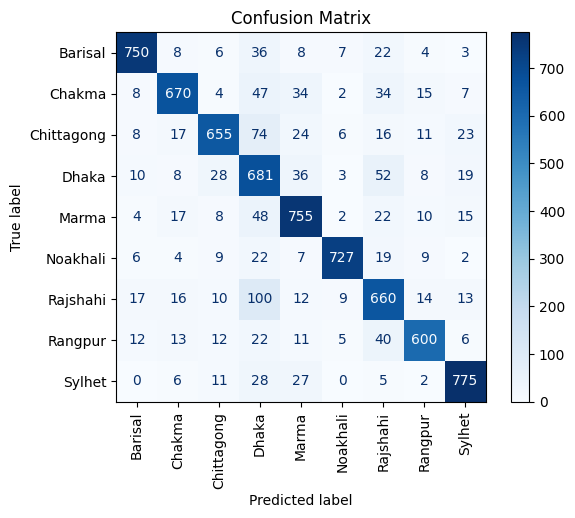

In [57]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Example data (replace these with your actual arrays)
logits = predictions.predictions
label_ids = predictions.label_ids  # Replace with your full label_ids array
label_mapping = {0: 'Barisal', 1: 'Chakma', 2: 'Chittagong', 3: 'Dhaka', 4: 'Marma', 5: 'Noakhali', 6: 'Rajshahi', 7: 'Rangpur', 8: 'Sylhet'}
# Convert logits to predicted class indices
predicted_labels = np.argmax(logits, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(label_ids, predicted_labels)
class_names = [label_mapping[i] for i in sorted(label_mapping.keys())]
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues,xticks_rotation='vertical' )
plt.title("Confusion Matrix")
plt.show()


In [51]:
from sklearn.metrics import classification_report
label_mapping = {0: 'Barisal', 1: 'Chakma', 2: 'Chittagong', 3: 'Dhaka', 4: 'Marma', 5: 'Noakhali', 6: 'Rajshahi', 7: 'Rangpur', 8: 'Sylhet'}
# Generate the classification report
report = classification_report(label_ids, predicted_labels, target_names=[label_mapping[i] for i in sorted(label_mapping.keys())])

# Print the report
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

     Barisal       0.92      0.89      0.90       844
      Chakma       0.88      0.82      0.85       821
  Chittagong       0.88      0.79      0.83       834
       Dhaka       0.64      0.81      0.72       845
       Marma       0.83      0.86      0.84       881
    Noakhali       0.96      0.90      0.93       805
    Rajshahi       0.76      0.78      0.77       851
     Rangpur       0.89      0.83      0.86       721
      Sylhet       0.90      0.91      0.90       854

    accuracy                           0.84      7456
   macro avg       0.85      0.84      0.84      7456
weighted avg       0.85      0.84      0.84      7456



In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# # Mapping of numeric labels to class names
# label_mapping = {0: 'Barisal', 1: 'Chakma', 2: 'Chittagong', 3: 'Dhaka', 4: 'Marma', 5: 'Noakhali', 6: 'Rajshahi', 7: 'Rangpur', 8: 'Sylhet'}

# # Extract true labels
# true_labels = np.array(dd['test']['label'])

# # Predicted labels
# predicted_labels = predictions

# # Generate the confusion matrix
# cm = confusion_matrix(true_labels, predicted_labels)

# # Get class names in order
# class_names = [label_mapping[i] for i in sorted(label_mapping.keys())]

# # Display the confusion matrix with class names and a blue color map
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
# disp.plot(cmap='Blues', xticks_rotation='vertical')

# plt.title("Confusion Matrix")
# plt.show()


In [ ]:
# model_name = "wav2vec2-base-960h"
# kwargs = {
#     "dataset_tags": "thisisjibon/banglabeats",
#     "dataset": "BanglaBeats",
#     "model_name": f"{model_name}-finetuned-banglabeats",
#     "finetuned_from": "facebook/wav2vec2-base-960h",
#     "tasks": "audio-classification",
# }
# trainer.push_to_hub(**kwargs)

In [ ]:
# from transformers import pipeline

# pipe=pipeline('audio-classification',model=model_name,device=0)

In [ ]:
# # disco example
# audio,rate=torchaudio.load('/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/disco/disco.00005.wav')
# transform=torchaudio.transforms.Resample(rate,RATE_HZ)
# audio=transform(audio).numpy().reshape(-1)
# # make a classification pipeline
# pipe(audio)

In [ ]:
# # classical example
# audio,rate=torchaudio.load('/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00014.wav')
# transform=torchaudio.transforms.Resample(rate,RATE_HZ)
# audio=transform(audio).numpy().reshape(-1)
# # make a classification pipeline
# pipe(audio)

In [ ]:
# from IPython.display import Audio
# Audio(audio,rate=RATE_HZ)

# Send model to Huggingface

In [ ]:
# # finally, save the model to Huggingface
# from huggingface_hub import notebook_login
# notebook_login()

In [ ]:
# from huggingface_hub import HfApi
# api = HfApi()
# repo_id = f"thisisjibon/{model_name}"
# try:
#     api.create_repo(repo_id)
# except:
#     print(f"Repo {repo_id} already exists")

In [ ]:
# api.upload_folder(
#     folder_path=model_name,
#     path_in_repo = ".",
#     repo_id=repo_id,
#     repo_type="model"
# )